# Cell type differences and effects of interferon stimulation on immune cells

Demonstrating differential expression between cell types and the effect of interferon stimulation within a cell type (CD4 T cells).

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import scanpy.api as sc
import scipy as sp
import itertools
import numpy as np
import scipy.stats as stats
from scipy.integrate import dblquad
import seaborn as sns
from statsmodels.stats.multitest import fdrcorrection
import imp
import time

In [3]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'figure.titlesize':'xx-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)


In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
from sklearn.decomposition import PCA

In [6]:
from sklearn.preprocessing import StandardScaler

In [7]:
import sys
sys.path.append('/Users/mincheolkim/Github/scrna-parameter-estimation/simplesc')
import simplesc

In [8]:
data_path = '/Users/mincheolkim/Google Drive/UCSF/research/parameter_estimation/interferon_data/'

### Perform some basic filtering

In [9]:
adata = sc.read(data_path + 'interferon.raw.h5ad')

In [10]:
adata.obs.cell.value_counts()

CD4 T cells          10373
CD14+ Monocytes       5355
B cells               2570
CD8 T cells           2039
NK cells              1991
FCGR3A+ Monocytes     1592
Dendritic cells        432
Megakaryocytes         208
Name: cell, dtype: int64

In [10]:
adata.obs.head(5)

,tsne1,tsne2,ind,stim,cluster,cell,multiplets,n_genes,n_counts
index,,,,,,,,,
AAACATACATTTCC-1,-27.640373,14.966629,1016,ctrl,9,CD14+ Monocytes,singlet,878,3017.0
AAACATACCAGAAA-1,-27.493646,28.924885,1256,ctrl,9,CD14+ Monocytes,singlet,713,2481.0
AAACATACCATGCA-1,-10.468194,-5.984389,1488,ctrl,3,CD4 T cells,singlet,337,703.0
AAACATACCTCGCT-1,-24.367997,20.429285,1256,ctrl,9,CD14+ Monocytes,singlet,850,3420.0
AAACATACCTGGTA-1,27.952170,24.159738,1039,ctrl,4,Dendritic cells,singlet,1111,3158.0


In [11]:
adata.obs.head(5)

,tsne1,tsne2,ind,stim,cluster,cell,multiplets,n_genes,n_counts
index,,,,,,,,,
AAACATACATTTCC-1,-27.640373,14.966629,1016,ctrl,9,CD14+ Monocytes,singlet,878,3017.0
AAACATACCAGAAA-1,-27.493646,28.924885,1256,ctrl,9,CD14+ Monocytes,singlet,713,2481.0
AAACATACCATGCA-1,-10.468194,-5.984389,1488,ctrl,3,CD4 T cells,singlet,337,703.0
AAACATACCTCGCT-1,-24.367997,20.429285,1256,ctrl,9,CD14+ Monocytes,singlet,850,3420.0
AAACATACCTGGTA-1,27.952170,24.159738,1039,ctrl,4,Dendritic cells,singlet,1111,3158.0


In [12]:
adata.obs['cell_type'] = (adata.obs['cell'].astype(str) + ' - ' + adata.obs['stim'].astype(str)).astype('category')

saving figure to file ./figures/tsne_all_ct.png


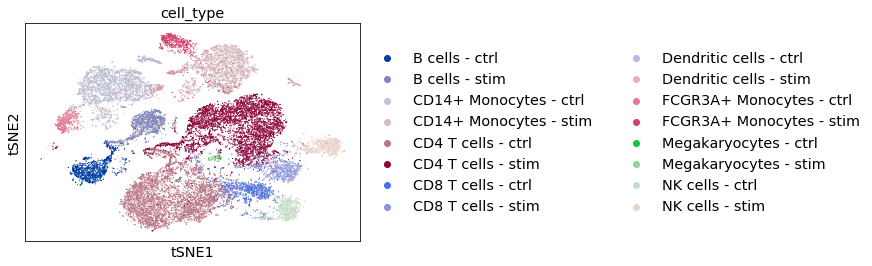

In [13]:
sc.pl.tsne(adata, color='cell_type', save='_all_ct.png')

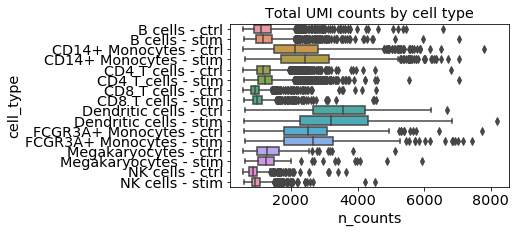

In [14]:
plt.figure(figsize=(5, 3))
sns.boxplot(x='n_counts', y='cell_type', data=adata.obs)
plt.title('Total UMI counts by cell type')
plt.savefig('celltype_numi.pdf')
plt.savefig('celltype_numi.png')

In [15]:
print('Number of genes kept:', adata.shape[1])

Number of genes kept: 1884


### Cell type markers

In [20]:
adata_ctrl = adata[adata.obs.stim == 'ctrl'].copy()

In [21]:
imp.reload(simplesc)
estimator = simplesc.SingleCellEstimator(
    adata=adata_ctrl, 
    group_label='cell',
    n_umis_column='n_counts',
    num_permute=10000,
    p=0.1)

In [22]:
for ct in adata_ctrl.obs.cell.drop_duplicates():
    
    print('Calculating stats for {}'.format(ct))
    
    estimator.compute_observed_moments(ct)
    estimator.compute_estimated_moments(ct)
    estimator.compute_params(ct)
    estimator.compute_observed_moments('-' + ct)
    estimator.compute_estimated_moments('-' + ct)
    estimator.compute_params('-' + ct)
    estimator.hypothesis_test_1d('-' + ct, ct)
    upreg_stats, upreg_genes = estimator.get_increased_exp_genes('-' + ct, ct, num_genes=25)
    
    print(upreg_genes)

Calculating stats for CD14+ Monocytes
['C15orf48' 'IL8' 'SOD2' 'S100A11' 'CD63' 'TYROBP' 'S100A8' 'GAPDH'
 'FCER1G' 'S100A4' 'LGALS1' 'LGALS3' 'ANXA5' 'EMP3' 'LYZ' 'S100A9' 'ANXA2'
 'TYMP' 'CD14' 'MARCKSL1' 'HLA-DRB1' 'NFKBIA' 'GPX1' 'CTSB' 'CSTB']
Calculating stats for CD4 T cells
['LTB' 'CCR7' 'CD3D' 'SELL' 'RGCC' 'LEPROTL1' 'IL7R' 'OCIAD2' 'ITM2A'
 'CD7' 'TRAT1' 'CREM' 'PIK3IP1' 'LCK' 'CD3E' 'CD2' 'TSC22D3' 'GIMAP5'
 'C6orf48' 'GIMAP4' 'CD52' 'LAT' 'SPOCK2' 'LEF1' 'AES']
Calculating stats for Dendritic cells
['HLA-DRB1' 'TXN' 'HLA-DPB1' 'HLA-DPA1' 'LYZ' 'C15orf48' 'HLA-DQA1' 'CST3'
 'GAPDH' 'HLA-DQB1' 'ANXA2' 'CCR7' 'LGALS1' 'GPR183' 'EMP3' 'IL8'
 'MARCKSL1' 'IDO1' 'CD63' 'S100A11' 'NFKBIA' 'HLA-DMA' 'BIRC3' 'SERPINB1'
 'INSIG1']
Calculating stats for NK cells
['GNLY' 'CCL5' 'NKG7' 'GZMB' 'APOBEC3G' 'CST7' 'FGFBP2' 'CLIC3' 'CD7'
 'RARRES3' 'PRF1' 'GZMA' 'KLRD1' 'CTSW' 'CCL4' 'CHST12' 'GZMH' 'CD247'
 'APMAP' 'HOPX' 'TNFRSF18' 'CLEC2B' 'KLRC1' 'SEPT7' 'ALOX5AP']
Calculating stats for 

## Effect of interferon stimulation across cell types

### Scatter plot of estimated 1D parameters

In [51]:
imp.reload(simplesc)
estimator = simplesc.SingleCellEstimator(
    adata=adata, 
    group_label='cell_type',
    n_umis_column='n_counts',
    num_permute=10000,
    p=0.1)

In [170]:
for ct in adata.obs.cell_type.drop_duplicates():
    
    print('Calculating stats for {}'.format(ct))
    
    estimator.compute_observed_moments(ct)
    estimator.compute_estimated_moments(ct)
    estimator.compute_params(ct)
    estimator.compute_confidence_intervals(ct)
    

Calculating stats for CD14+ Monocytes - ctrl
Calculating stats for CD4 T cells - ctrl
Calculating stats for Dendritic cells - ctrl
Calculating stats for NK cells - ctrl
Calculating stats for CD8 T cells - ctrl
Calculating stats for B cells - ctrl
Calculating stats for Megakaryocytes - ctrl
Calculating stats for FCGR3A+ Monocytes - ctrl
Calculating stats for CD8 T cells - stim
Calculating stats for Dendritic cells - stim
Calculating stats for B cells - stim
Calculating stats for CD4 T cells - stim
Calculating stats for CD14+ Monocytes - stim
Calculating stats for Megakaryocytes - stim
Calculating stats for NK cells - stim
Calculating stats for FCGR3A+ Monocytes - stim


In [69]:
ct = 'CD14 T cells'

In [70]:
estimated_means = estimator.parameters[ct + ' - ctrl']['log_mean']
estimated_var = estimator.estimated_central_moments[ct + ' - ctrl']['second']
estimated_disp = estimator.parameters[ct + ' - ctrl']['log_dispersion']

In [150]:
plt.style.use('ggplot')

In [151]:
idx = (estimated_means < 100) & (estimated_disp < 100)

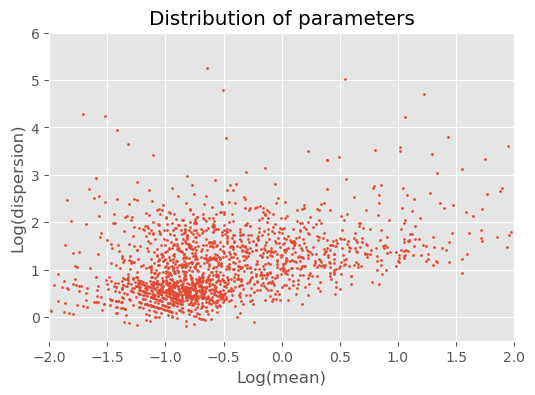

In [169]:
plt.figure(figsize=(6, 4))
plt.scatter(estimated_means[idx], estimated_disp[idx], s=2);
plt.xlim(-2, 2);
plt.ylim(-0.5, 6);
plt.ylabel('Log(dispersion)');
plt.xlabel('Log(mean)')
plt.title('Distribution of parameters')
plt.savefig('mean_disp_distribution.png')
plt.savefig('mean_disp_distribution.pdf')

### Perform hypothesis testing, get deltas in log(mean) and log(dispersion)

In [196]:
for ct in adata.obs.cell.drop_duplicates():
    
    print('Calculating stats for {}'.format(ct))
    
    estimator.hypothesis_test_1d(ct + ' - ctrl', ct + ' - stim')

Calculating stats for CD14+ Monocytes
Calculating stats for CD4 T cells
Calculating stats for Dendritic cells
Calculating stats for NK cells
Calculating stats for CD8 T cells
Calculating stats for B cells
Calculating stats for Megakaryocytes
Calculating stats for FCGR3A+ Monocytes


In [197]:
key = frozenset(['CD4 T cells - ctrl', 'CD4 T cells - stim'])

In [200]:
mean_delta = estimator.hypothesis_test_result_1d[key]['de_diff']
disp_delta = estimator.hypothesis_test_result_1d[key]['dv_diff']

In [ ]:
cutoff = 0.1

In [ ]:
de_sig = estimator.hypothesis_test_result_1d[key]['de_fdr'] < cutoff
dv_sig = estimator.hypothesis_test_result_1d[key]['dv_fdr'] < cutoff


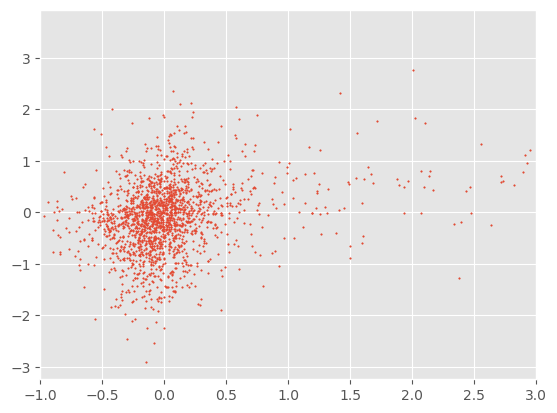

In [206]:
plt.scatter(mean_delta, disp_delta, s=1);
plt.xlim(-1, 3);

In [520]:
upreg_genes_dict = {}
downreg_genes_dict = {}
inc_var_genes_dict = {}
dec_var_genes_dict = {}
only_inc_var_genes_dict = {}
only_dec_var_genes_dict = {}
only_upreg_genes_dict = {}
for ct in adata_ctrl.obs.cell.drop_duplicates():
    
    print('Calculating stats for {}'.format(ct))
    upreg_stats, upreg_genes = estimator.get_differential_genes(
        ct + ' - ctrl', ct + ' - stim', 'mean', 'increase',
        num_genes=10000, sig=0.15)
    downreg_stats, downreg_genes = estimator.get_differential_genes(
        ct + ' - ctrl', ct + ' - stim', 'mean', 'decrease',
        num_genes=10000, sig=0.15)
    inc_var_stats, inc_var_genes = estimator.get_differential_genes(
        ct + ' - ctrl', ct + ' - stim', 'dispersion', 'increase',
        num_genes=10000, sig=0.15)
    dec_var_stats, dec_var_genes = estimator.get_differential_genes(
        ct + ' - ctrl', ct + ' - stim', 'dispersion', 'decrease',
        num_genes=10000, sig=0.15)
    upreg_genes_dict[ct] = upreg_genes
    downreg_genes_dict[ct] = downreg_genes
    inc_var_genes_dict[ct] = inc_var_genes
    dec_var_genes_dict[ct] = dec_var_genes
    only_inc_var_genes_dict[ct] = list(set(inc_var_genes) - set(upreg_genes) - set(downreg_genes))
    only_upreg_genes_dict[ct] = list(set(upreg_genes) - set(inc_var_genes))
    only_dec_var_genes_dict[ct] = list(set(dec_var_genes) - set(upreg_genes) - set(downreg_genes))

dec_genes = set()
for key, genes in dec_var_genes_dict.items():
    dec_genes |= set(genes)
inc_genes = set()
for key, genes in inc_var_genes_dict.items():
    inc_genes |= set(genes)
    

Calculating stats for CD14+ Monocytes
Calculating stats for CD4 T cells
Calculating stats for Dendritic cells
Calculating stats for NK cells
Calculating stats for CD8 T cells
Calculating stats for B cells
Calculating stats for Megakaryocytes
Calculating stats for FCGR3A+ Monocytes


In [ ]:
print(upreg_genes_dict)
print(downreg_genes_dict)
print(inc_var_genes_dict)
print(dec_var_genes_dict)

### Expression changes across CT for a gene

In [567]:
def plot_exp_changes_across_ct(gene, estimator, barwidth=0.3):
    
    plt.figure(figsize=(11, 6))
    
    plt.subplots_adjust(hspace=0.1)
    
    groups = estimator.anndata.obs['cell'].drop_duplicates()
    
    labels = estimator.anndata.obs['cell'].drop_duplicates()
    labels = [label.replace(' ', '\n') for label in labels]
    labels[-2] = 'Megaka\nryocytes'
    
    gene_idx = np.where(adata.var.index == gene)[0][0]
    
    ctrl_means = np.array([estimator.parameters[group + ' - ctrl']['mean'][gene_idx] for group in groups])
    stim_means = np.array([estimator.parameters[group + ' - stim']['mean'][gene_idx] for group in groups])
    ctrl_means_ci = np.array([estimator.parameters_confidence_intervals[group + ' - ctrl']['log1p_mean'][gene_idx] for group in groups])
    stim_means_ci = np.array([estimator.parameters_confidence_intervals[group + ' - stim']['log1p_mean'][gene_idx] for group in groups])
    
    ctrl_vars = np.array([estimator.parameters[group + ' - ctrl']['dispersion'][gene_idx] for group in groups])
    stim_vars = np.array([estimator.parameters[group + ' - stim']['dispersion'][gene_idx] for group in groups])
    ctrl_vars_ci = np.array([estimator.parameters_confidence_intervals[group + ' - ctrl']['log1p_dispersion'][gene_idx] for group in groups])
    stim_vars_ci = np.array([estimator.parameters_confidence_intervals[group + ' - stim']['log1p_dispersion'][gene_idx] for group in groups])
    
    ctrl_loc = np.arange(len(ctrl_means)) - barwidth/2
    stim_loc = np.arange(len(ctrl_means)) + barwidth/2
    
    plt.subplot(2, 1, 1)
    plt.title('{} Expression in response to IFN-B'.format(gene))
    plt.bar(
        ctrl_loc, 
        np.log(ctrl_means+1), 
        width=barwidth,
        yerr=ctrl_means_ci,
        capsize=5
    )
    plt.bar(
        stim_loc, 
        np.log(stim_means+1), 
        width=barwidth,
        yerr=stim_means_ci,
        capsize=5
    )
    plt.xticks([])
    plt.legend(['control', 'IFN-B'])
    plt.ylabel('Log(mean+1)')
    plt.ylim(0, max(np.log(ctrl_means+1).max(), np.log(stim_means+1).max()) + 1)
    
    plt.subplot(2, 1, 2)
    plt.bar(
        ctrl_loc, 
        np.log(ctrl_vars+1), 
        width=barwidth,
        yerr=ctrl_vars_ci,
        capsize=5
    )
    plt.bar(
        stim_loc, 
        np.log(stim_vars+1), 
        width=barwidth,
        yerr=stim_vars_ci,
        capsize=5
    )
    plt.xticks(np.arange(len(ctrl_means)), labels)
    plt.ylim(0, max(np.log(ctrl_vars+1).max(), np.log(stim_vars+1).max()) + 1)
    plt.ylabel('Log(dispersion+1)')

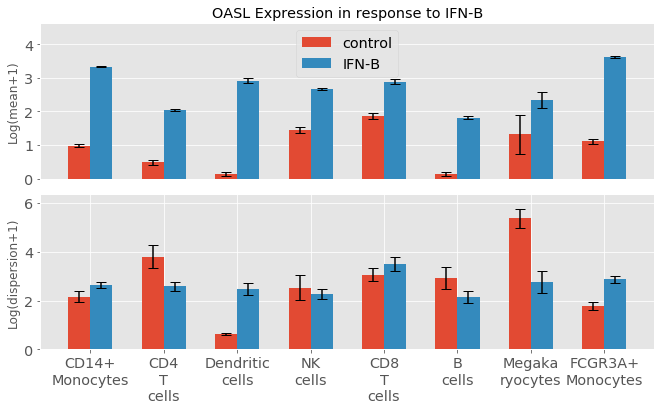

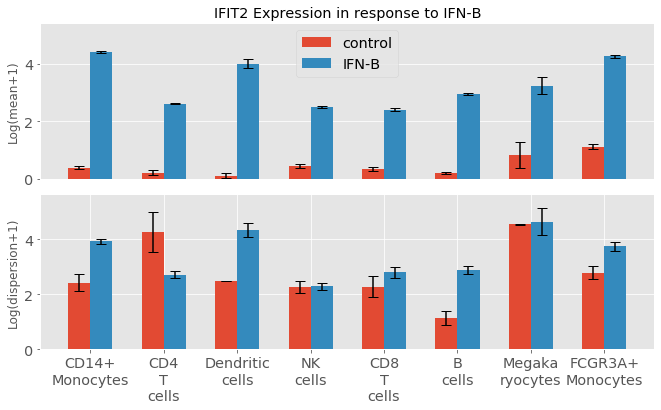

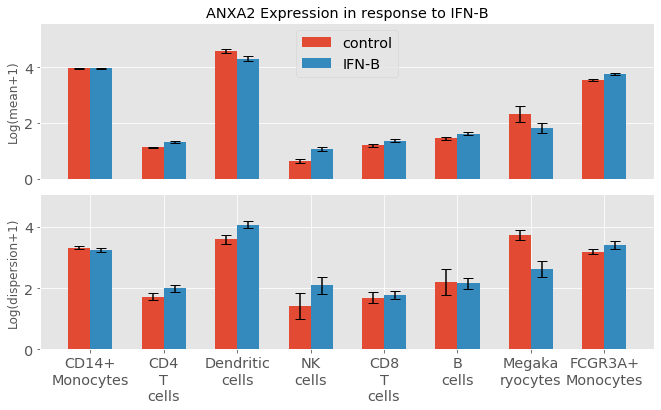

In [583]:
for gene in ['OASL', 'IFIT2', 'ANXA2']:
    plot_exp_changes_across_ct(gene, estimator)
    plt.savefig('{}_across_ct.pdf'.format(gene))
    plt.savefig('{}_across_ct.png'.format(gene))

### Expression changes across different genes for a CT

In [191]:
def plot_exp_across_genes(genes, ct, barwidth=0.3):

    plt.figure(figsize=(len(genes)*1.5, 7))
    
    genes_idx = [np.where(adata.var.index == gene)[0][0] for gene in genes]
    
    ctrl_means = np.array([estimator.parameters[ct + ' - ctrl']['mean'][gene_idx] for gene_idx in genes_idx])
    stim_means = np.array([estimator.parameters[ct + ' - stim']['mean'][gene_idx] for gene_idx in genes_idx])
    ctrl_means_ci = np.array([estimator.parameters_confidence_intervals[ct + ' - ctrl']['log1p_mean'][gene_idx] for gene_idx in genes_idx])
    stim_means_ci = np.array([estimator.parameters_confidence_intervals[ct + ' - stim']['log1p_mean'][gene_idx] for gene_idx in genes_idx])

    ctrl_vars = np.array([estimator.parameters[ct + ' - ctrl']['dispersion'][gene_idx] for gene_idx in genes_idx])
    stim_vars = np.array([estimator.parameters[ct + ' - stim']['dispersion'][gene_idx] for gene_idx in genes_idx])
    ctrl_vars_ci = np.array([estimator.parameters_confidence_intervals[ct + ' - ctrl']['log1p_dispersion'][gene_idx] for gene_idx in genes_idx])
    stim_vars_ci = np.array([estimator.parameters_confidence_intervals[ct + ' - stim']['log1p_dispersion'][gene_idx] for gene_idx in genes_idx])
    
    ctrl_loc = np.arange(len(ctrl_means)) - barwidth/2
    stim_loc = np.arange(len(ctrl_means)) + barwidth/2
    labels = genes
    
    plt.subplot(2, 1, 1)
    plt.title('Expression changes in {}'.format(ct))
    plt.bar(
        ctrl_loc, 
        np.log(ctrl_means+1), 
        width = barwidth,
        yerr=ctrl_means_ci,
        capsize=5
    )
    plt.bar(
        stim_loc, 
        np.log(stim_means+1), 
        width = barwidth,
        yerr=stim_means_ci,
        capsize=5
    )
    plt.ylim(0, max(np.log(ctrl_means+1).max(), np.log(stim_means+1).max()) + 0.5)
    plt.xticks([])
    plt.legend(['control', 'IFN-B'])
    plt.ylabel('Log(mean+1)')
    
    plt.subplot(2, 1, 2)
    plt.bar(
        ctrl_loc, 
        np.log(ctrl_vars+1), 
        width = barwidth,
        yerr=ctrl_vars_ci,
        capsize=5
    )
    plt.bar(
        stim_loc, 
        np.log(stim_vars+1), 
        width = barwidth,
        yerr=stim_vars_ci,
        capsize=5
    )
    plt.ylim(0, max(np.log(ctrl_vars+1).max(), np.log(stim_vars+1).max()) + 1.4)
    plt.xticks(np.arange(len(ctrl_means)), labels)
    plt.ylabel('Log(dispersion+1)')

In [192]:
genes_1 = ['PTCD3', 'CDK12', 'RAB3GAP1', 'FAS', 'SETX']
# both sig, only var sig, both sig, both sig, both sig, only var

In [193]:
genes_2 = ['IFIT1', 'IFIT2', 'IFIT3', 'IFITM3', 'IFIT5']

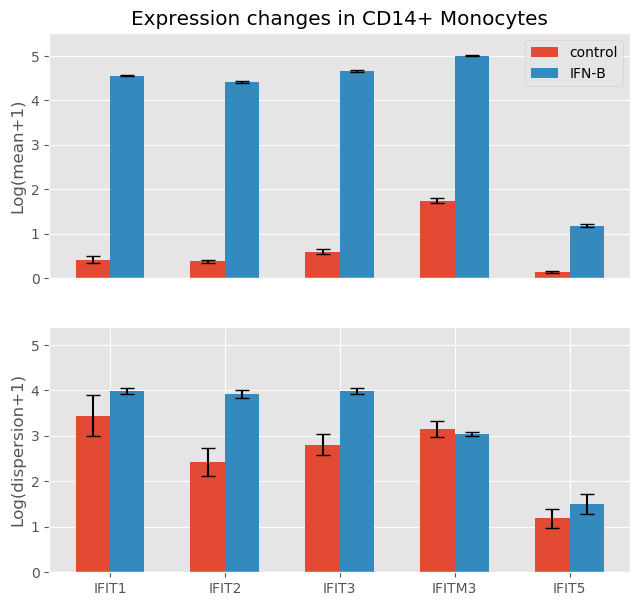

In [194]:
plot_exp_across_genes(genes_2, 'CD14+ Monocytes', barwidth=0.3)
plt.savefig('monocytes_across_ifi_genes.png')

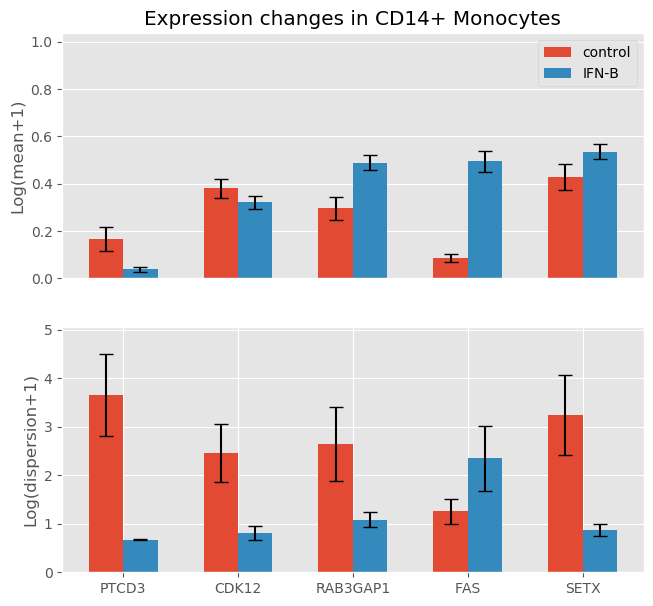

In [195]:
plot_exp_across_genes(genes_1, 'CD14+ Monocytes', barwidth=0.3)
plt.savefig('monocytes_across_other_genes.png')

### Pseudotime interferon stimulation analysis

In [313]:
cd4_pt_df = pd.read_csv(data_path + 'cd4_timepoints.csv', index_col=0)
cd4_adata = adata[adata.obs.cell == 'CD4 T cells'].copy()
cd4_adata.obs['stim_tp'] = cd4_pt_df['stim_tp'].astype(str)
cd4_stim_adata = cd4_adata[cd4_adata.obs.stim == 'stim'].copy()
cd4_stim_adata.obs['stim_tp'] = cd4_stim_adata.obs['stim_tp'].replace('5', '4')



In [314]:
imp.reload(simplesc)
stim_tp_estimator = simplesc.SingleCellEstimator(
    adata=cd4_stim_adata, 
    group_label='stim_tp',
    n_umis_column='n_counts',
    num_permute=10000,
    p=0.1)

In [315]:
for tp in cd4_stim_adata.obs.stim_tp.drop_duplicates():
    
    print('Calculating stats for {}'.format(tp))
    
    stim_tp_estimator.compute_observed_moments(tp)
    stim_tp_estimator.compute_estimated_moments(tp)
    stim_tp_estimator.compute_params(tp)
    stim_tp_estimator.compute_confidence_intervals(tp)

Calculating stats for 2
Calculating stats for 0
Calculating stats for 1
Calculating stats for 3
Calculating stats for 4


In [592]:
def plot_param_trajectory(gene, estimator, x_axis_width, y_axis_width):
    
    groups = [str(i) for i in range(5)]
    
    gene_idx = np.where(adata.var.index == gene)[0][0]
    
    means = np.array([estimator.parameters[group]['log_mean'][gene_idx] for group in groups])
    dispersions = np.array([estimator.parameters[group]['log_dispersion'][gene_idx] for group in groups])
    
    means_ci = [estimator.parameters_confidence_intervals[group]['log_mean'][gene_idx] for group in groups]
    dispersions_ci = [estimator.parameters_confidence_intervals[group]['log_dispersion'][gene_idx] for group in groups]
    
    plt.errorbar(
        x=means, 
        y=dispersions,
        xerr=means_ci,
        yerr=dispersions_ci,
        fmt='.-',
        capsize=2,
        ecolor='k')
    plt.title(gene)
    
    offset=0.03
    for i, label in enumerate(groups):
        plt.annotate(label, (means[i], dispersions[i]+dispersions_ci[i]+offset))
    
    axes = plt.gca()
    ymin, ymax = axes.get_ylim()
    xmin, xmax = axes.get_xlim()
    
    ymid = (ymin + ymax)/2
    xmid = (xmin + xmax)/2
    
    axes.set_xlim([xmid - x_axis_width, xmid + x_axis_width])
    axes.set_ylim([ymid - y_axis_width, ymid + y_axis_width])
    
    axes.xaxis.set_major_locator(plt.MultipleLocator(0.5))
    
    

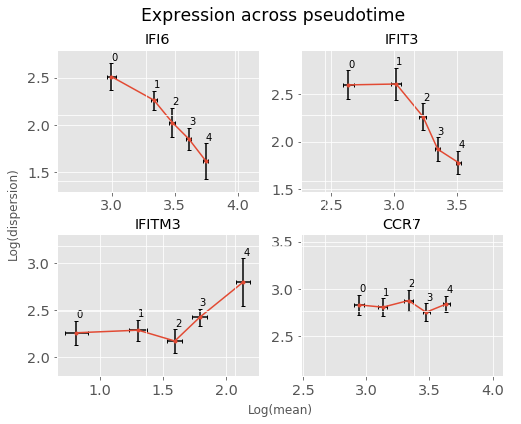

In [593]:
x_width = 0.8
y_width = 0.75
fig = plt.figure(figsize=(8, 6))
plt.suptitle('Expression across pseudotime')
plt.subplots_adjust(hspace=0.3, wspace=0.21)
plt.subplot(2, 2, 1)
plot_param_trajectory(
    gene='IFI6', 
    estimator=stim_tp_estimator,
    y_axis_width=y_width,
    x_axis_width=x_width)
plt.subplot(2, 2, 2)
plot_param_trajectory(
    gene='IFIT3', 
    estimator=stim_tp_estimator,
    y_axis_width=y_width,
    x_axis_width=x_width)
plt.subplot(2, 2, 3)
plot_param_trajectory(
    gene='IFITM3', 
    estimator=stim_tp_estimator,
    y_axis_width=y_width,
    x_axis_width=x_width)
plt.subplot(2, 2, 4)
plot_param_trajectory(
    gene='CCR7', 
    estimator=stim_tp_estimator,
    y_axis_width=y_width,
    x_axis_width=x_width)

ax = fig.add_subplot(111, frameon=False);
plt.tick_params(
    which='both',
    length=0,
    labelcolor='none', 
    top='off', 
    bottom='off', 
    left='off', 
    right='off');
ax.set_xlabel('Log(mean)', labelpad=10);
ax.set_ylabel('Log(dispersion)', labelpad=10);
plt.savefig('pseudotime.pdf')
plt.savefig('pseudotime.png')

### Differential correlation

In [113]:
adata_ctrl = adata[adata.obs.stim == 'ctrl'].copy()

In [236]:
imp.reload(simplesc)
estimator = simplesc.SingleCellEstimator(
    adata=adata_ctrl, 
    group_label='cell',
    n_umis_column='n_counts',
    num_permute=10000,
    p=0.1)

In [237]:
ct_1 = 'Dendritic cells'
ct_2 = 'Megakaryocytes'

In [238]:
estimator.compute_observed_moments(ct_1)
estimator.compute_estimated_moments(ct_1)
estimator.compute_params(ct_1)


In [239]:
estimator.compute_observed_moments(ct_2)
estimator.compute_estimated_moments(ct_2)
estimator.compute_params(ct_2)


In [240]:
%%time
estimator.hypothesis_test_2d(ct_1, ct_2, ['CST7', 'IL8'], ['ID3', 'ANXA2'])

0.08774614334106445
0.1759331226348877
0.17682409286499023
0.29093503952026367
0.2918050289154053
------
0.2517881393432617
0.519766092300415
0.525015115737915
0.8669891357421875
0.8679690361022949
------
0.6348316669464111
1.4870448112487793
1.4879648685455322
2.8112969398498535
2.812116861343384
------
1.053415060043335
2.5744659900665283
2.5751819610595703
5.131809949874878
5.13249397277832
------
CPU times: user 6.67 s, sys: 2.83 s, total: 9.5 s
Wall time: 9.32 s


In [235]:
%%time
estimator.hypothesis_test_2d(ct_1, ct_2, ['CST7', 'IL8'], ['ID3', 'ANXA2'])

0.0717158317565918
0.19289302825927734
0.19494009017944336
0.3053410053253174
0.3062911033630371
------
0.25130605697631836
0.616260290145874
0.61971116065979
0.9411211013793945
0.941824197769165
------
0.631676197052002
1.9707250595092773
1.9716112613677979
3.3119101524353027
3.313019037246704
------
1.1251001358032227
4.058524131774902
4.059325933456421
6.766273021697998
6.766947984695435
------
CPU times: user 8.39 s, sys: 3.2 s, total: 11.6 s
Wall time: 11.5 s


In [220]:
estimator.hypothesis_test_result_2d[frozenset([ct_1, ct_2])]

{'dc_diff': matrix([[ 0.00560849, -0.53431162],
         [-0.09998574,  0.18945053]]),
 'gene_idx_1': array([1689,  464]),
 'gene_idx_2': array([  21, 1426]),
 'dc_pval': array([[7.726e-01, 4.000e-04],
        [3.587e-01, 1.109e-01]]),
 'dc_fdr': array([[0.7726    , 0.0016    ],
        [0.47826667, 0.2218    ]])}